Online-Kurs zu Modellierung und Simulation, Goethe-Universität-Frankfurt | [Startseite](../index.ipynb)

---

# Beispiel: Hodgkin-Huxley-Modell


Betrachte die gewöhnliche DGL
\begin{align*}
\dot V &= \frac{1}{C} \cdot (I - I_K - I_{Na} - I_L)\\
\dot n &= \alpha_n(V) \cdot (1-n) - \beta_n(V) \cdot n\\ 
\dot m &= \alpha_m(V) \cdot (1-m) - \beta_m(V) \cdot m\\
\dot h &= \alpha_h(V) \cdot (1-h) - \beta_h(V) \cdot h
\end{align*}
mit den Strömen:
\begin{align*}
I_K &:= \overline g_K n^4 (V-E_K) \\
I_{Na} &:= \overline g_{Na} m^3 h (V-E_{Na}) \\
I_{L} &:= \overline g_{L} (V-E_{Na})
\end{align*}
Dabei ist $V$ das Membranpotential und $0 \le m,n,h \le 1$ sind Wahrscheinlichkeiten, dass Kanäle offen sind. 

## Definitionen
### Globale Parameter

In [1]:
global gk = 0.36*100;    # in mS/ cm^2
global gna = 1.2*100;    # in mS/ cm^2
global gl = 0.003*100;   # in mS / cm^2
global C = 1.0;          # in \mu F / cm^2
global Ek = -77;         # in mV
global Ena = 50;         # in mV
global El = -54.4;       # in mV

### Funktionen
Definiere für die Gatingvariablen $m$, $n$ und $h$ die jeweiligen Raten $\alpha$, $\beta$:

In [2]:
function value = alphan(V) 
value = (0.01*(V+55))/(1-exp(-0.1*(V+55)));
endfunction

function value = betan(V) 
value = 1/8*exp(-(V+65)/80);
endfunction

function value = alpham(V) 
  value = (0.1*(V+40))/(1-exp(-0.1*(V+40)));
endfunction


function value = betam(V) 
value = 4.0*exp(-(V+65)/18.0);
endfunction

function value = alphah(V) 
value = 0.07*exp(-(V+65.0)/20.0);
endfunction

function value = betah(V) 
value = 1/(1+exp(-0.1*(V+35.0)));
endfunction



Separate Definition der **Leitfähigkeiten**:

In [3]:

function value = Gk(V,n)
global gk;
value = gk *n*n*n*n;
endfunction

function value = Gna(V,m,h)
global gna;
value = gna *(m*m*m)*(h);
endfunction

Definition der **Ströme**:

In [4]:
function value = Ik(V,n)
global gk;
global Ek;
value = gk*(n*n*n*n)*(V-Ek);
endfunction

function value = Ina(V,m,h)
global gna;
global Ena;
value = gna*(m*m*m)*h*(V-Ena); # *h
endfunction

function value = Il(V)
global gl;
global El;
value = gl*(V-El);
endfunction

function value = Isum (V,n,m,h)
value = Ik(V,n)+Ina(V,m,h) + Il(V);
endfunction


Definition des **Eingangssignal** (in $\mu A/cm^2$):

In [5]:
function value = Istep(t)
if (t >= 2 && t<= 2.5) value = 8; return;
elseif(t >= 10 && t<= 10.5) value = 30.0; return;
# elseif(t >= 15 && t<= 15.5) value = 30.0; return;
endif
value = 0;
endfunction


## Numerische Lösung
### Definition der rechten Seite der DGL

In [6]:
function value=f_hh(x, t)
	 global C;
   
	 V = x(1);
	 n = x(2);
	 m = x(3);
	 h = x(4);
	 
	 value(1) = (Istep(t) - Ik(V,n) - Ina(V,m,h) - Il(V))/C;
	 value(2) = alphan(V) * (1.0-n) - betan(V)*n;
	 value(3) = alpham(V) * (1.0-m) - betam(V)*m;
	 value(4) = alphah(V) * (1.0-h) - betah(V)*h;
endfunction

### Anfangswerte

In [7]:
x0=[-65 0.32 0.052 0.6]'
t0 = 0.0;
tend = 40.0;

x0 =

  -65.000000
    0.320000
    0.052000
    0.600000



### Löser
Wir lösen die DGL mittels `lsode`. Dazu definieren wir mittels `linspace` einen Vektor `mytimes` mit 500 äquidistant verteilten Punkten im Intervall $[0,T_{sim}]$. 

In [8]:
# Loese das AWP numerisch
time = linspace(t0, tend, 2000);
sol = lsode(@f_hh, x0, time);

*Hinweis:* Alternativ könnten hier auch eigene Module verwendet werden:

In [9]:
addpath("../basics")
exist("extrapolation_explicit_adaptive")

ans =  2


# Diagramme

Konfiguration der Plots als Vektorgrafik

In [10]:
%plot -f svg

Erzeuge Shortcuts für Lösungen

In [11]:
Vtime=sol(:,1);
ntime = sol(:,2);
mtime = sol(:,3);
htime = sol(:,4);

### Diagramm 1: Membranpotential V

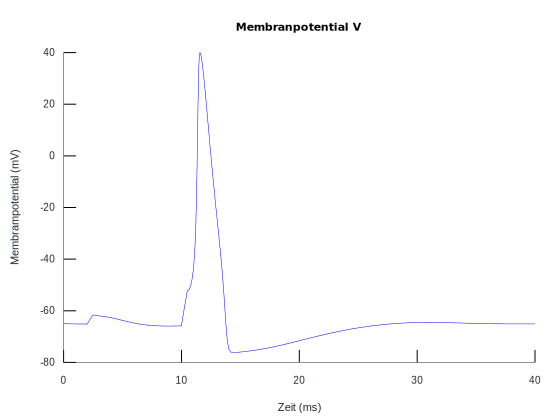

In [12]:
newplot
hold on
xlabel('Zeit (ms)')
ylabel('Membrampotential (mV)')
title('Membranpotential V')
plot (time(1,:),Vtime, 'color', 'blue');
# plot (time(1,:), -65.0, 'color', 'red');
hold off



### Diagramm 2: Aktivierungsvariablen m,n,h

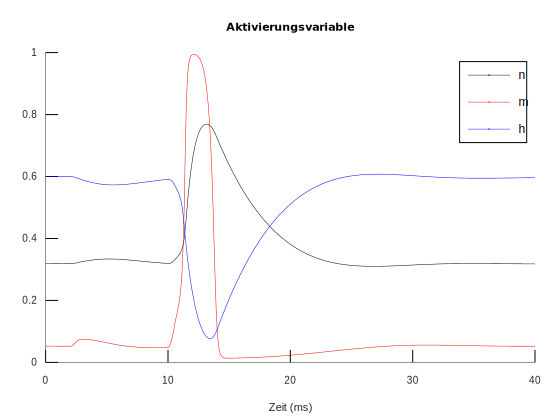

In [13]:
newplot()
# Konfiguriere Diagramm 2
# fig1=subplot(4,1,2);
xlabel('Zeit (ms)')
title('Aktivierungsvariable')#, "verticalalignment")
hold on
nt = sol(:,2);
plot (time(1,:), ntime, 'color', 'black');
plot (time(1,:), mtime, 'color', 'red');
plot (time(1,:), htime, 'color', 'blue');
h = legend ('n', 'm', 'h');
set (h, 'fontsize', 12);
hold off


### Diagramm 3: Ströme

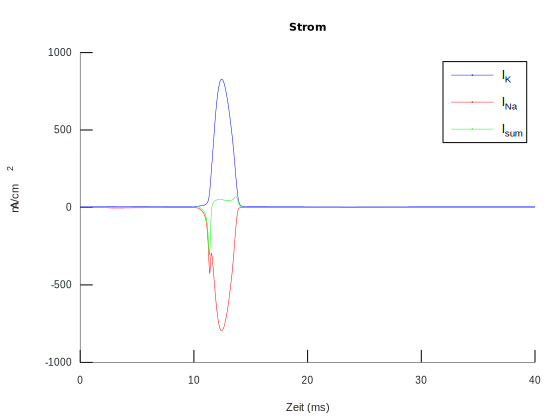

In [14]:
IkTime=arrayfun(@Ik, Vtime, ntime);
InaTime=arrayfun(@Ina, Vtime, mtime, htime);
IsumTime=arrayfun(@Isum, Vtime, ntime, mtime, htime);

xlabel('Zeit (ms)')
title('Strom')
ylabel('\mu A/cm^2')
hold on
plot (time(1,:), IkTime, 'color', 'blue');
plot (time(1,:), InaTime, 'color', 'red');
plot (time(1,:), IsumTime, 'color', 'green');
hold off
h = legend ('I_K', 'I_{Na}', 'I_{sum}');
set (h, 'fontsize', 12);


### Diagramm 4: Leitfähigkeiten

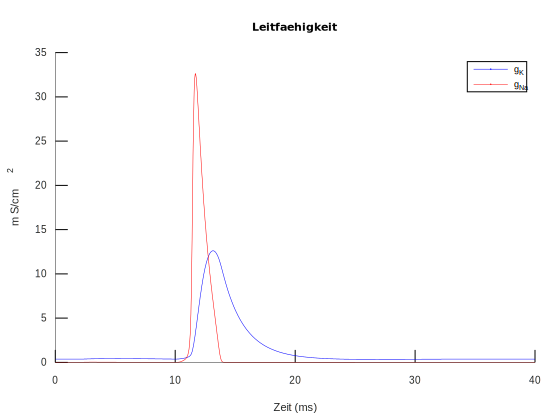

In [15]:
# Diagramm 4
GkTime=arrayfun(@Gk, Vtime, ntime);
GnaTime=arrayfun(@Gna, Vtime, mtime, htime);

hold on
plot (time(1,:), GkTime, 'color', 'blue');
plot (time(1,:), GnaTime, 'color', 'red');
hold off
h = legend ('g_K', 'g_{Na}', "location", "northeast");
title('Leitfaehigkeit')
ylabel('m S/cm^2')
xlabel('Zeit (ms)')

